In [23]:
! pip install xgboost hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached py4j-0.10.9.9-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   --------------- ------------------------ 0.8/2.0 MB 3.4 MB/s eta 0:00:01
   ------------------------- -------------- 1.3/2.0 MB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 3.0 MB/s eta 0:00:00
Using cached future-1.0.0-py3-none-any.whl (491 kB)
Using cached py4j-0.10.9.9-py2.py3-none-any.whl (203 kB)

   ---------------------------------------- 0/4 [py4j]
   ---------------------------------------- 0/4 [py4j]
   ---------------------------------------- 0/4 [py4j]
   ---------------------------------------- 0/4 [py4j]
   ---------------------------------------- 0/

In [ ]:

import requests
from xgboost import XGBRegressor
import os
import pickle
import mlflow
import numpy as np
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import mlflow.xgboost

In [ ]:
import mlflow


mlflow.set_tracking_uri("http://localhost:5000")


experiment_name = "test_experiment"
mlflow.set_experiment(experiment_name)

2025/07/01 19:31:36 INFO mlflow.tracking.fluent: Experiment with name 'test_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/mlflow/artifacts/1', creation_time=1751391096537, experiment_id='1', last_update_time=1751391096537, lifecycle_stage='active', name='test_experiment', tags={}>

In [ ]:
def fetch_turnstile_data(date: str):
    url = f"https://data.ny.gov/resource/k7j9-jnct.json?date={date}"
    response = requests.get(url)
    if response.status_code == 200:
        return pd.DataFrame(response.json())
    else:
        print(f"Failed to load data for {date}")
        return pd.DataFrame()

dates = [f"2022-01-{day:02d}" for day in range(10, 24)]
dfs = [fetch_turnstile_data(date) for date in dates]
df_raw = pd.concat(dfs, ignore_index=True)


In [ ]:
df_raw["entries"] = pd.to_numeric(df_raw["entries"], errors="coerce")
df_raw["date"] = pd.to_datetime(df_raw["date"])
df_raw["datetime"] = df_raw["date"].astype(str) + " " + df_raw["time"]
df_raw["datetime"] = pd.to_datetime(df_raw["datetime"], errors="coerce")

df_raw = df_raw.dropna(subset=["entries", "datetime", "c_a", "unit", "scp"])

df_raw = df_raw.sort_values(["c_a", "unit", "scp", "datetime"])
df_raw["entries_diff"] = df_raw.groupby(["c_a", "unit", "scp"])["entries"].diff()
df_raw["exits_diff"] = df_raw.groupby(["c_a", "unit", "scp"])["exits"].diff()
df_raw['ridership'] = df_raw["entries_diff"] + df_raw["exits_diff"]


df_raw["group_key"] = df_raw["c_a"] + '_'+ '_'+ df_raw['unit']

df_agg = (
    df_raw.groupby(["group_key", "datetime"])["ridership"]
    .sum()
    .reset_index()
    .rename(columns={"ridership": "entries_4h"})
)

df_agg = df_agg.sort_values(['group_key', "datetime"])

def add_features(df):
    df["lag_1"] = df.groupby(['group_key'])["entries_4h"].shift(1)
    df["lag_6"] = df.groupby(["group_key"])["entries_4h"].shift(6)
    df["rolling_mean_3"] = df.groupby(["group_key"])["entries_4h"].transform(
        lambda x: x.shift(1).rolling(3).mean()
    )
    df["hour"] = df["datetime"].dt.hour
    df["day_of_week"] = df["datetime"].dt.weekday
    return df.dropna()

df_features = add_features(df_agg)

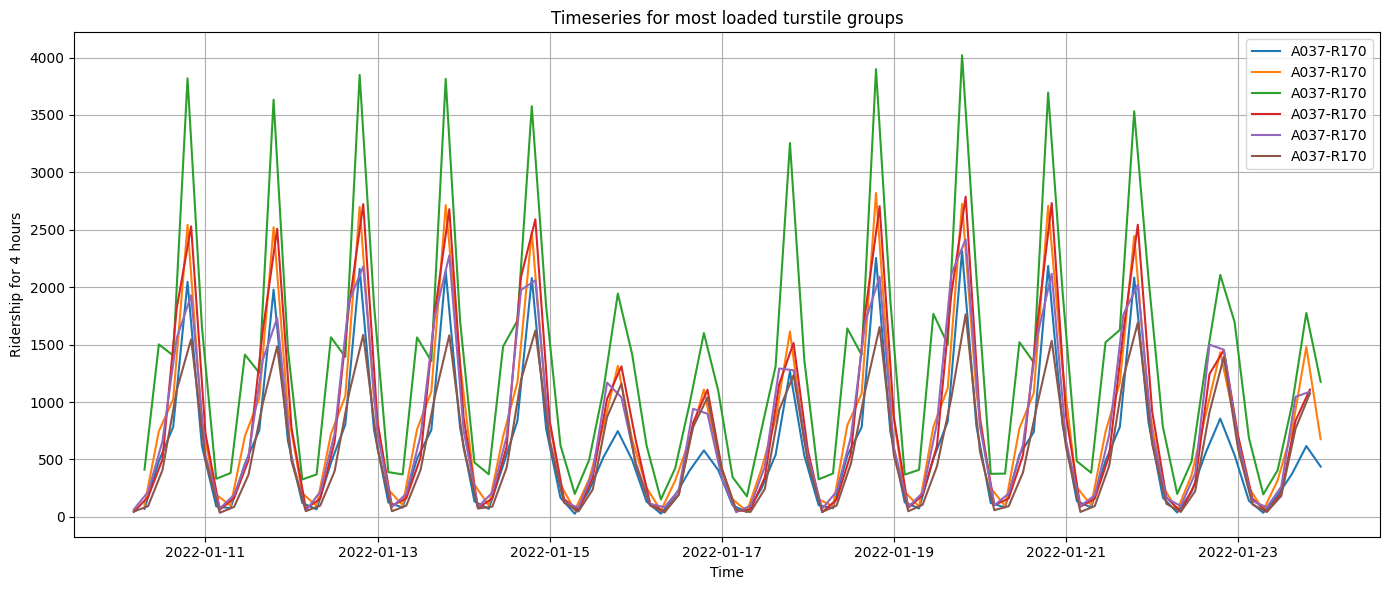

In [ ]:
top_units = (
    df_agg.groupby(['group_key'])["entries_4h"]
    .sum()
    .sort_values(ascending=False)
    .head(6)
    .index
)

df_top = df_agg.set_index(["group_key"]).loc[top_units].reset_index()

plt.figure(figsize=(14, 6))
for (group_key), group in df_top.groupby(["group_key"]):
    group = group.sort_values("datetime")
    plt.plot(group["datetime"], group["entries_4h"], label=f"{ca}-{unit}")

plt.xlabel("Time")
plt.ylabel("Ridership for 4 hours")
plt.title("Timeseries for most loaded turstile groups")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [66]:
cutoff = pd.to_datetime("2022-01-22 23:59:59")
train = df_features[df_features["datetime"] <= cutoff]
test = df_features[df_features["datetime"] > cutoff]

FEATURES = ["lag_1", "lag_6", "rolling_mean_3", "hour", "day_of_week", "group_key"]

df_features["group_key"] = df_features["group_key"].astype("category")
TARGET = "entries_4h"

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]


C:\Users\miron\AppData\Local\Temp\ipykernel_75852\625586700.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["group_key"] = df_features["group_key"].astype("category")


In [ ]:
os.makedirs("output", exist_ok=True)

with open("output/train.pkl", "wb") as f_out:
    pickle.dump((X_train, y_train), f_out)

with open("output/val.pkl", "wb") as f_out:
    pickle.dump((X_test, y_test), f_out)


In [ ]:

mlflow.set_tracking_uri("http://127.0.0.1:5000") 
mlflow.set_experiment("xgboost-hyperopt")

def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        data = pickle.load(f_in)
        return data[0].copy(), data[1].copy()


def run_opt(data_path="./output", num_trials=20):
    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

    for df in [X_train, X_val]: 
      df["group_key"] = df["group_key"].astype("category")

    def objective(params):
        with mlflow.start_run():
            mlflow.set_tag("model", "xgboost")
            mlflow.log_params(params)

            model = XGBRegressor(**params, enable_categorical=True)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            rmse = root_mean_squared_error(y_val, y_pred)
            mae = mean_absolute_error(y_val, y_pred)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("mae", mae)

        return {'loss': rmse, 'status': STATUS_OK}

    search_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
        'learning_rate': hp.loguniform('learning_rate', -3, 0),  # ~0.05–1.0
        'reg_alpha': hp.loguniform('reg_alpha', -3, 1),
        'reg_lambda': hp.loguniform('reg_lambda', -3, 1),
        'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 10)),
        'random_state': 42,
        'verbosity': 0
    }

    rstate = np.random.default_rng(42)
    best_result = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=num_trials,
        trials=Trials(),
        rstate=rstate
    )

    print("Best hyperparameters:", best_result)
    
    return best_result


In [80]:
best_result = run_opt(data_path="./output", num_trials=30)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

🏃 View run likeable-skink-660 at: http://127.0.0.1:5000/#/experiments/1/runs/f43edff0bb5b4cab95343fe7a15d397b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

🏃 View run thoughtful-mouse-352 at: http://127.0.0.1:5000/#/experiments/1/runs/0936286cd537435ab0925b685a7f52c7

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                   

🏃 View run aged-duck-134 at: http://127.0.0.1:5000/#/experiments/1/runs/4c5cd6439a064851aad1822c2c30ecf4

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                  

🏃 View run clean-grub-941 at: http://127.0.0.1:5000/#/experiments/1/runs/cd2f933450b3488ab5216d5a591e4b07

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                  

🏃 View run traveling-skink-588 at: http://127.0.0.1:5000/#/experiments/1/runs/f91baf3c3b324fbf819d2319b15a07d4

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                  

🏃 View run polite-squid-289 at: http://127.0.0.1:5000/#/experiments/1/run

In [73]:
best_result

{'learning_rate': np.float64(0.14851714658681),
 'max_depth': np.float64(5.0),
 'min_child_weight': np.float64(5.0),
 'n_estimators': np.float64(250.0),
 'reg_alpha': np.float64(1.2921840771542246),
 'reg_lambda': np.float64(1.697353748763298)}

In [78]:
df_meta

(      lag_1  lag_6  rolling_mean_3  hour  day_of_week   group_key
 77    538.0  168.0      652.333333     3            6  A002__R051
 78    140.0   38.0      511.333333     7            6  A002__R051
 79     36.0  218.0      238.000000    11            6  A002__R051
 80    188.0  563.0      121.333333    15            6  A002__R051
 81    374.0  856.0      199.333333    19            6  A002__R051
 ...     ...    ...             ...   ...          ...         ...
 1987  335.0   12.0      229.666667     7            6  A042__R086
 1988   18.0   31.0      158.333333    11            6  A042__R086
 1989   25.0  108.0      126.000000    15            6  A042__R086
 1990  141.0  232.0       61.333333    19            6  A042__R086
 1991  206.0  122.0      124.000000    23            6  A042__R086
 
 [144 rows x 6 columns],
 77      140.0
 78       36.0
 79      188.0
 80      374.0
 81      617.0
         ...  
 1987     18.0
 1988     25.0
 1989    141.0
 1990    206.0
 1991     58.0
 Nam

In [84]:
! pip install --upgrade mlflow

d:\courses\mlops_dtalks\mlops_zoomcamp_2025\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [18:27:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run indecisive-hound-133 at: http://127.0.0.1:5000/#/experiments/2/runs/3caff5c286334425af643cb58733f7b9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


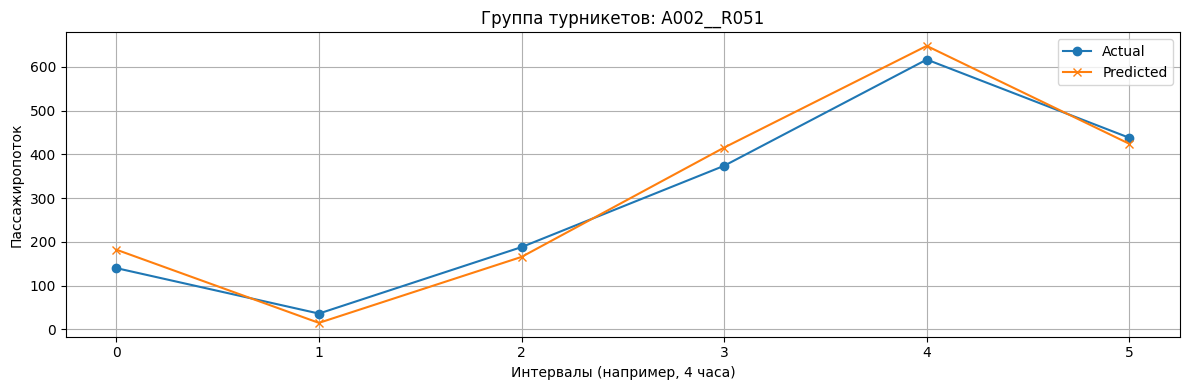

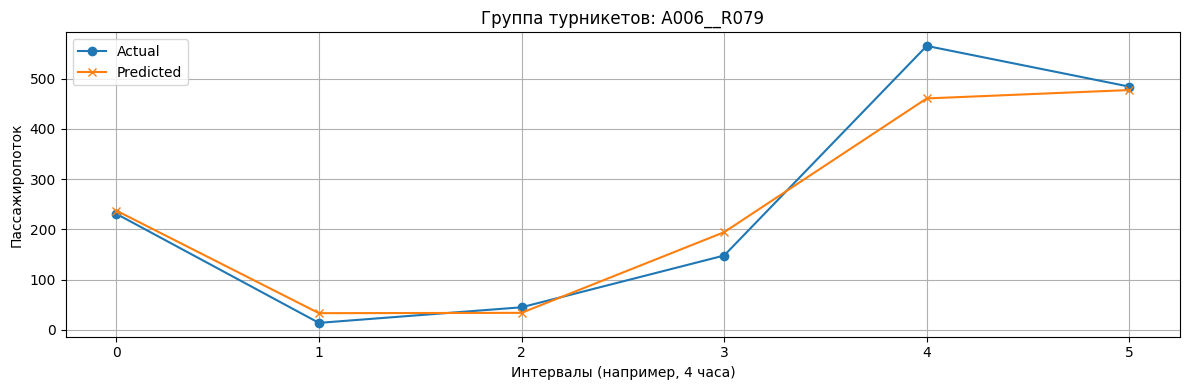

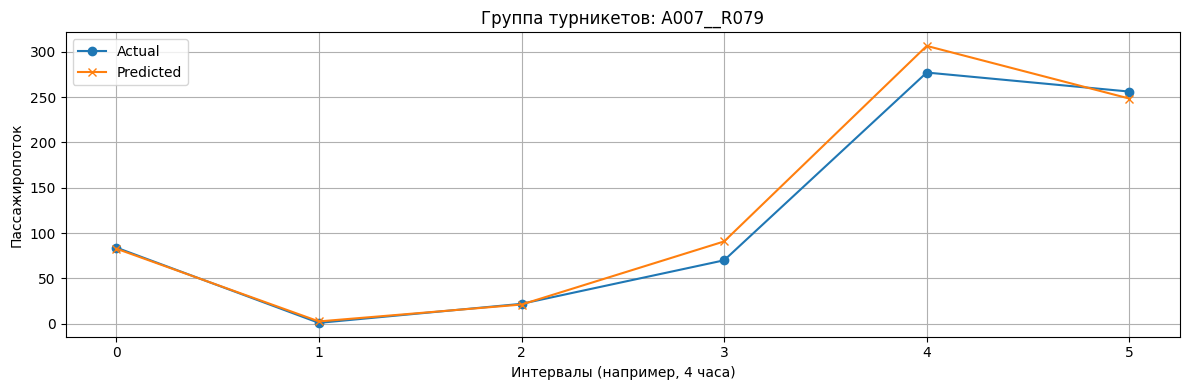

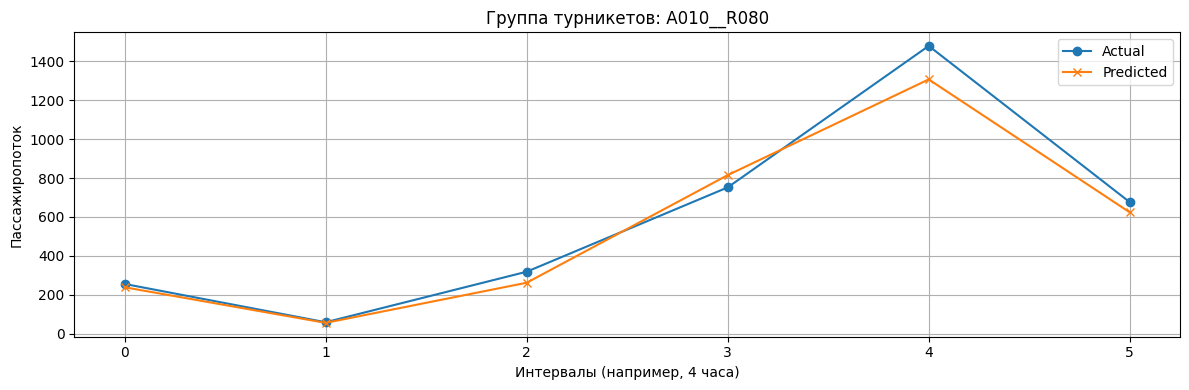

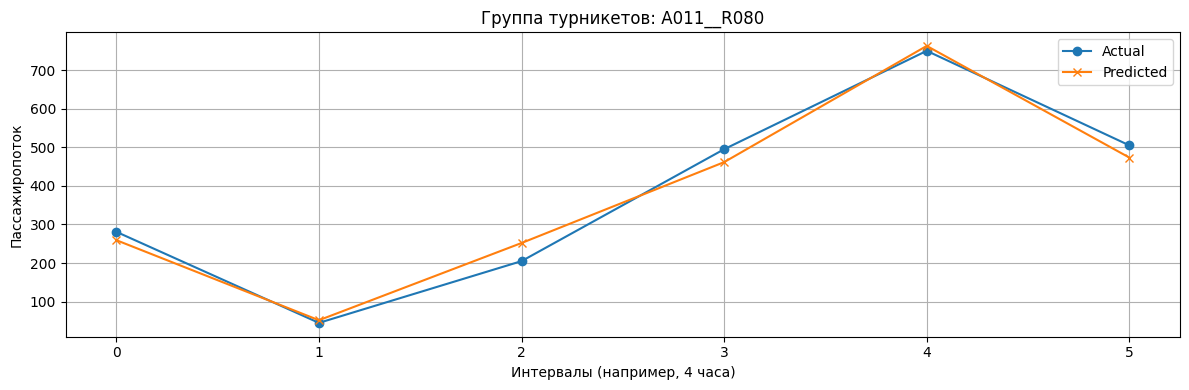

In [ ]:
# Установить URI и эксперимент
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("xgboost-best-model")

# Загрузка данных
with open("./output/train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)
with open("./output/val.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

# Приводим group_key к категориальному типу
for df in [X_train, X_test]:
    df["group_key"] = df["group_key"].astype("category")

# Для визуализации и группировки
with open("./output/val.pkl", "rb") as f:
    df_meta, y_test = pickle.load(f)

# Гиперпараметры
best_params = {
    'max_depth': int(best_result['max_depth']),
    'min_child_weight': int(best_result['min_child_weight']),
    'reg_alpha': best_result['reg_alpha'],
    'reg_lambda': best_result['reg_lambda'],
    'learning_rate': best_result['learning_rate'],
    'objective': 'reg:squarederror',
    'seed': 42,
    'verbosity': 0
}

with mlflow.start_run():
    mlflow.set_tag("model_type", "xgboost")
    mlflow.log_params(best_params)

    # Обучение модели
    model = xgb.XGBRegressor(**best_params, enable_categorical=True)
    model.fit(X_train, y_train)

    # Предсказания
    y_pred = model.predict(X_test)

    # Логгирование метрик
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    mlflow.log_metric("rmse", rmse)

    # Логгирование модели
    mlflow.xgboost.save_model(model, path="xgb_model_local")  # локально
    mlflow.log_artifacts("xgb_model_local", artifact_path="model")  

# Визуализация
df_meta = df_meta.copy()
df_meta["y_true"] = y_test
df_meta["y_pred"] = y_pred

groups_to_plot = df_meta["group_key"].unique()[:5]

for group in groups_to_plot:
    df_group = df_meta[df_meta["group_key"] == group]
    plt.figure(figsize=(12, 4))
    plt.plot(df_group["y_true"].values, label="Actual", marker="o")
    plt.plot(df_group["y_pred"].values, label="Predicted", marker="x")
    plt.title(f"Группа турникетов: {group}")
    plt.xlabel("Интервалы (например, 4 часа)")
    plt.ylabel("Пассажиропоток")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
